# Application of Fourier Flows to Synthetic Data

In this notebook, we reproduce the first experiment (Section 5.1) in our paper "Generative Time-series Modeling with Fourier Flows" published in ICLR 2021 by Ahmed M. Alaa, Alex Chan and Mihaela van der Schaar. 

In [2]:
from data.synthetic import *
from utils.spectral import *
from SequentialFlows import *
from models.sequential import *
from timegan import timegan

import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### Sampling synthetic data

Here we consider the following time-series data generation process:

$x = \sin(ft + \phi),$ $\phi \sim \mathcal{N}(0,1)$, $f \sim Beta(\alpha, \beta), t \in \{0, \ldots, T-1\}$

In [31]:
T           = 101
n_samples   = 1000
X           = sine_data_generation(no=n_samples, seq_len=T, dim=1)

### Fitting the Fourier Flows and Real-NVP models

Imported from "SequentialFlows"

In [32]:
FF_model    = FourierFlow(hidden=200, fft_size=T, n_flows=10, normalize=False) 
RVP_model   = RealNVP(hidden=200, T=T, n_flows=10) 

In [33]:
FF_losses   = FF_model.fit(X, epochs=1000, batch_size=128, 
                           learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 127.790
step: 100 	/ 1000 	|---------	loss: -386.018
step: 200 	/ 1000 	||--------	loss: -475.344
step: 300 	/ 1000 	|||-------	loss: -506.549
step: 400 	/ 1000 	||||------	loss: -543.507
step: 500 	/ 1000 	|||||-----	loss: -535.393
step: 600 	/ 1000 	||||||----	loss: -585.423
step: 700 	/ 1000 	|||||||---	loss: -610.268
step: 800 	/ 1000 	||||||||--	loss: -631.442
step: 900 	/ 1000 	|||||||||-	loss: -629.874
step: 999 	/ 1000 	||||||||||	loss: -649.791
Finished training!


In [6]:
RVP_losses  = RVP_model.fit(X, epochs=1000, batch_size=128, 
                            learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 206.286
step: 100 	/ 1000 	|---------	loss: 100.722
step: 200 	/ 1000 	||--------	loss: 79.333
step: 300 	/ 1000 	|||-------	loss: 49.133
step: 400 	/ 1000 	||||------	loss: 25.909
step: 500 	/ 1000 	|||||-----	loss: 3.969
step: 600 	/ 1000 	||||||----	loss: -21.087
step: 700 	/ 1000 	|||||||---	loss: -42.715
step: 800 	/ 1000 	||||||||--	loss: -59.821
step: 900 	/ 1000 	|||||||||-	loss: -47.814
step: 999 	/ 1000 	||||||||||	loss: -66.084
Finished training!


### Sample from Fourier flows and Real-NVP models

In [34]:
X_gen_FF   = FF_model.sample(1000)
X_gen_RVP  = RVP_model.sample(1000)

### Load saved TimeGAN sample

In [65]:
# Uncomment to lead the results from the run used in the paper

#RealNVP        = pickle.load(open("experiment1_RealNVP.p", "rb"))
#RealNVP_losses = pickle.load(open("experiment1_RealNVP_losses.p", "rb"))

#FF             = pickle.load(open("experiment1_FF.p", "rb"))
#FF_losses      = pickle.load(open("experiment1_FF_losses.p", "rb"))

TGAN           = pickle.load(open("results//experiment1_TimeGAN.p", "rb"))
X_gen_TGAN     = [TGAN[k].reshape((-1,)) for k in range(len(TGAN))] 

### Fitting predictive RNN models

In [66]:
predictive_model_TGAN    = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_RealNVP = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_FF      = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)

In [67]:
X_FF                     = [X_gen_FF[k][:len(X_gen_FF[k])-1] for k in range(len(X_gen_FF))]
Y_FF                     = [X_gen_FF[k][1:] for k in range(len(X_gen_FF))]

X_RealNVP                = [X_gen_RVP [k][:len(X_gen_RVP [k])-1] for k in range(len(X_gen_RVP ))]
Y_RealNVP                = [X_gen_RVP [k][1:] for k in range(len(X_gen_RVP ))]

X_TGAN                   = [X_gen_TGAN[k][:len(X_gen_TGAN[k])-1] for k in range(len(X_gen_TGAN))]
Y_TGAN                   = [X_gen_TGAN[k][1:] for k in range(len(X_gen_TGAN))]

In [50]:
predictive_model_FF.fit(X_FF, Y_FF)

Epoch:  0 | train loss: 0.3292
Epoch:  1 | train loss: 0.0275
Epoch:  2 | train loss: 0.0273
Epoch:  3 | train loss: 0.0144
Epoch:  4 | train loss: 0.0170


In [51]:
predictive_model_RealNVP.fit(X_RealNVP, Y_RealNVP)

Epoch:  0 | train loss: 0.2832
Epoch:  1 | train loss: 0.2259
Epoch:  2 | train loss: 0.2684
Epoch:  3 | train loss: 0.2402
Epoch:  4 | train loss: 0.2185


In [68]:
predictive_model_TGAN.fit(X_TGAN, Y_TGAN)

Epoch:  0 | train loss: 0.3670
Epoch:  1 | train loss: 0.0817
Epoch:  2 | train loss: 0.0333
Epoch:  3 | train loss: 0.0321
Epoch:  4 | train loss: 0.0317


### Visualizing the results

<AxesSubplot:>

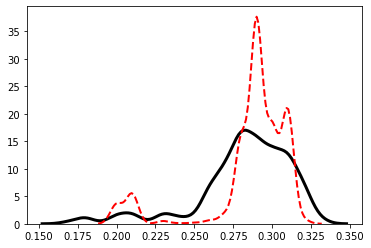

In [35]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_FF), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:>

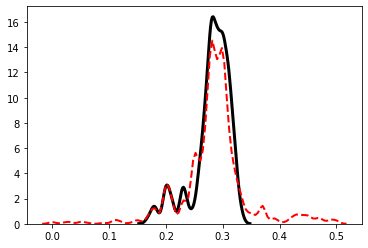

In [15]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_RVP), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:>

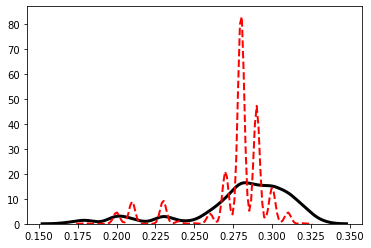

In [16]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_TGAN), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

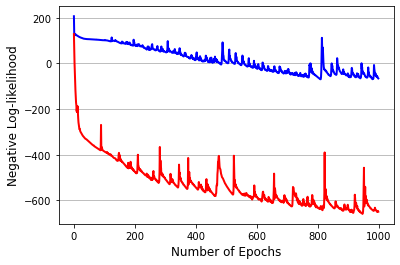

In [36]:
plt.plot(RVP_losses, linewidth=2, color="b")
plt.plot(FF_losses, linewidth=2, color="r")

plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("Negative Log-likelihood", fontsize=12)

plt.grid(axis="y")

In [47]:
FF_PSD_Errors      = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_FF))[:100]
RealNVP_PSD_Errors = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_RVP))[:100]
TGAN_PSD_Errors    = np.abs(power_spectral_density(X)[:199]-power_spectral_density(X_gen_TGAN))[:100]

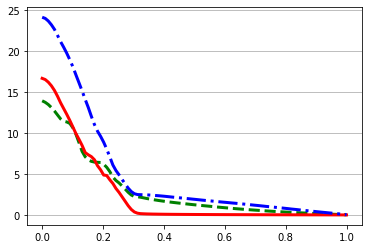

In [48]:
freqs              = np.linspace(0, 1, 100)

plt.plot(freqs, np.cumsum(TGAN_PSD_Errors)[::-1], linewidth=3, color="g", linestyle="--")
plt.plot(freqs, np.cumsum(FF_PSD_Errors)[::-1], linewidth=3, color="r")
plt.plot(freqs, np.cumsum(RealNVP_PSD_Errors)[::-1], linewidth=3, color="b", linestyle="-.")

plt.grid(axis="y")

In [69]:
X_true                  = [X[k][:len(X[k])-1] for k in range(len(X))]
Y_true                  = [X[k][1:] for k in range(len(X))]

X_TGAN_pred             = predictive_model_TGAN.predict(X_true)
X_FF_pred               = predictive_model_FF.predict(X_true)
X_RealNVP_pred          = predictive_model_RealNVP.predict(X_true)

In [70]:
TGAN_RNN_errs    = np.mean(np.abs(np.array(X_TGAN_pred) - np.array(Y_true)), axis=0)
FF_RNN_errs      = np.mean(np.abs(np.array(X_FF_pred) - np.array(Y_true)), axis=0)
RealNVP_RNN_errs = np.mean(np.abs(np.array(X_RealNVP_pred) - np.array(Y_true)), axis=0)

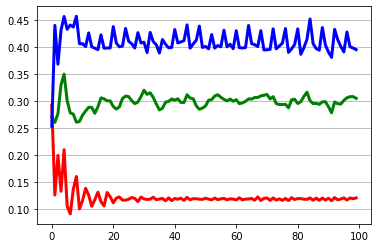

In [71]:
plt.plot(TGAN_RNN_errs, linewidth=3, color="g")
plt.plot(FF_RNN_errs, linewidth=3, color="r")
plt.plot(RealNVP_RNN_errs, linewidth=3, color="b")

plt.grid(axis="y")